Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Bayes Rule for Covid


Heavily influenced by Chapter 2 of [Kevin Murphy's *Probabalistic Machine Learning*](https://github.com/probml/pyprobml/blob/master/book1/chapters/chap2.md). Here we define and examine the relationship between sensitivity, specificity, prevalence, accuracy, precision, recall, and the posterior probability estimate.

1. A Bayesian approach to toy examples for the Covid PCR test.
   - define sensitivity, specificity
   - define precision and recall
2. Derive identities relating precision and accuracy to the others statistics.
3. Use that derivation to see how varying these measures affects the posterior.

In this analysis we assume that the statistics of a particular test are fixed but unknown; we allow the statistics to vary to understand its affect on the posterior. For an approach which does not assume these rates to be fixed but varying, see [Gelman and Carpenter (2020)](https://www.medrxiv.org/content/10.1101/2020.05.22.20108944v2.abstract).

# The Posterior

In [ ]:
import numpy as np

def normalize(x):
  return x / np.sum(x)

def posterior_covid(pcr_result,       # observation
                    prevalence=.1,    # prior
                    sensitivity=.875, # hyper-parameter
                    specificity=.975  # hyper-parameter
                    ):
  # observed pcr_result = 0 for negative test, 1 for positive test
  # hidden state = 0 if no-covid, 1 if have-covid
  TPR = sensitivity; 
  FNR = 1-TPR
  TNR = specificity
  FPR = 1-TNR

  # likelihood(hidden, obs)
  likelihood_fn = np.array([[TNR, FPR],
                            [FNR, TPR]])

  # prior(hidden)  
  prior = np.array([1-prevalence, prevalence])
  likelihood = likelihood_fn[:, pcr_result].T
  posterior = normalize(prior * likelihood)
  return posterior[1]

In [ ]:
def prevalence_report(prevalence):
  print("prevalence = %.0f%%" % (prevalence*100))
  for i, label in enumerate(("negative", "positive")):
    print(f"PCR:{label} -> p(have covid) = "
          f"{100*posterior_covid(i, prevalence):4.1f}%")

In [ ]:
prevalence_report(.1)

prevalence = 10%
PCR:negative -> p(have covid) =  1.4%
PCR:positive -> p(have covid) = 79.5%


In [ ]:
prevalence_report(.01)

prevalence = 1%
PCR:negative -> p(have covid) =  0.1%
PCR:positive -> p(have covid) = 26.1%


# Priors
How do they affect our model?

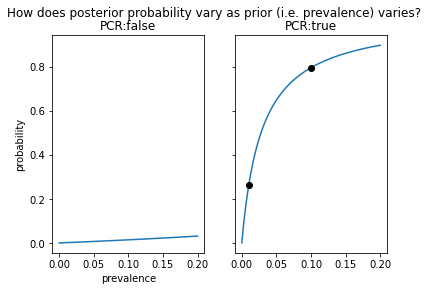

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

min_prior, max_prior = 0,.2

X = np.linspace(min_prior, max_prior, 100)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('How does posterior probability vary '
             'as prior (i.e. prevalence) varies?')

for i, (ax,label) in enumerate(zip(axes, "false true".split())):
  ax.plot(X, [posterior_covid(i, x) for x in X])
  ax.set_title("PCR:%s" % label)
  # ax.add_collection(
  #     PatchCollection(
  #         [Rectangle((min_prior, posterior_covid(1, min_prior)),
  #                     max_prior, posterior_covid(1, max_prior))],
  #                     edgecolor="black", facecolor="white"))
  if not i:
    ax.set_ylabel("probability")
    ax.set_xlabel("prevalence")
  else:
    prior = .1
    plt.plot(prior, posterior_covid(i, prior), marker="o", color='black')
    prior = .01
    plt.plot(prior, posterior_covid(i, prior), marker="o", color='black')

    

What does this graph mean? If 1% of the population has covid, a positive PCR test means you have a 26% chance of having Covid. "Oh no!" you might say, that means I probably don't have it even if I test positive. This is true, though we might ask how much more likely you are to have Covid with a positive test vs having Covid with a negative test. A 26% chance of having Covid vs a .1% chance of having covid is a pretty big difference: your chances of having Covid are now 260 times higher because of the positive test result.

In [ ]:
np.log(.261/.001), np.log(.795/.014)

(5.564520407322694, 4.039284785039073)

It is all well and good that we examine how our modeled probabilities vary with our prior. But it is easy to see that our prior is not the only assumption of this model. We are also making assumptions (supported with evidence) about the sensitivity and specificity of the PCR test. How do perturbations here affect our modeled probability? This is a different analysis to do conceptually but it is straightforward to see.

# Sensitivity
How does it affect our model?

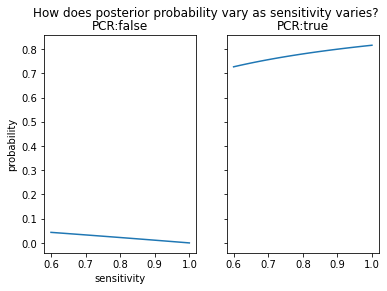

In [ ]:
X = np.linspace(.6, 1, 100)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('How does posterior probability vary as sensitivity varies?')

for i, (ax,label) in enumerate(zip(axes, "false true".split())):
  ax.plot(X, [posterior_covid(i, sensitivity=x) for x in X])
  if not i:
    ax.set_ylabel("probability")
    ax.set_xlabel("sensitivity")
  ax.set_title("PCR:%s" % label)

Answer: if sensitivity varies, our modeled probabilities do not change a great deal.

# Specificity
How does it affect our model?

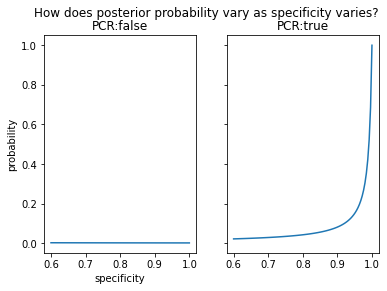

In [ ]:
X = np.linspace(.6, 1, 100)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('How does posterior probability vary as specificity varies?')

for i, (ax,label) in enumerate(zip(axes, "false true".split())):
  ax.plot(X, [posterior_covid(i, prevalence=.01, specificity=x) for x in X])
  if not i:
    ax.set_ylabel("probability")
    ax.set_xlabel("specificity")
  ax.set_title("PCR:%s" % label)

In [ ]:
# WOW
print(
    "*If* 10% of the population was infected and you test positive with a\n"
    "90%-specificity test, you would only have a "
    f"{100*posterior_covid(1, specificity=.9):.0f}% chance of actually having it.\n")

*If* 10% of the population was infected and you test positive with a
90%-specificity test, you would only have a 49% chance of actually having it.



# Priors and Specificity

Wow, the posterior probability looks to vary **extremely dramatically** as specificity varies.

Even a specificity of 90% wouldn't tell you much: if 10% of the population was infected, you would only have a 49% chance of actually having it if you tested positive.

Let's look at those curves for a few priors.

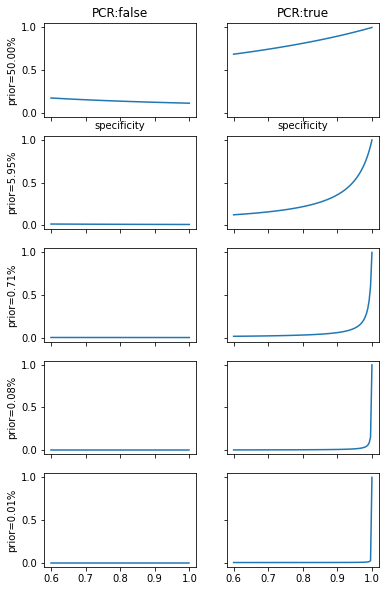

In [ ]:
num_rows = 5
priors = 10**np.linspace((np.log(.5) / np.log(10)), -4, num_rows)

fig, axes = plt.subplots(len(priors), 2, sharex=True, sharey=True)
for j, (prior, row) in enumerate(zip(priors, axes)):
  for i, (ax,label) in enumerate(zip(row, "false true".split())):
    ax.plot(X, [posterior_covid(i, prevalence=prior, specificity=x) for x in X])
    if not i and not j:
      ax.set_ylabel("probability")
    if not i:
      ax.set_ylabel("prior=%.2f%%" % (100*prior))
    if not j:
      ax.set_title("PCR:%s" % label)
      ax.set_xlabel("specificity")

fig.set_figheight(10)

### Upshot

If prevalence is low (under 8%) then specificity needs to be increasingly close to 100% in order to be able to conclude anything meaningful from `PCR=True`. This is less true for sensitivity/recall.

# Other Quality Statistics

There are several motivating questions:
1. How to measure how good a classifier is?
1. How can we quantify how good a test is?

If we were a toy manufacturer and some toys were defective, we might want to issue a recall of them. If we wanted be really sure we are really getting almost all of them, we would want a classification test with **high recall**. For the Covid PCR test, though, the point of the test is to empower individuals to know if they probably have it (i.e. have it with high posterior probability, given priors). This is better captured by a specificity measure, as we saw above. We will see below this is also well captured by a precision measure.

Another useful recall mnemonic is a memorization task. Given some items to remember (actual positives), what fraction of them can you *recall* (i.e. test positive).

Above, we defined sensitivity (aka recall), specificity, and prevalence. Now we define two other measures.

- Precision := $\frac {TP}{TP+FP}$.
- Accuracy := $\frac {TP+TN}{TP+FP+TN+FN}$.

In practice, different fields use 2 from that list of 4 and [everyone looks up](https://en.wikipedia.org/wiki/Confusion_matrix) the definition again if one of the measures is not listed. Just because different fields use different statistics, we don't need to confine ourselves to just a few because, thankfully, we can translate between each of them -- which is precisely what we will do below.


# Toy Example (aka a unit test)

We go through a toy example to test our understanding of each of the statistics and at the same time check our solutions to the exercises below.

Now let us suppose we have a PCR test but we don't actually know how effective it is. We have 17 sampled patients and we know some of them really do have Covid (say,  for the moment, we had some other way to *know* this) and some do not. We can use the actual prevalence of Covid in our population as a proxy for the prevalence in general, so from this small sample we can compute all the statistics we could care to know. And we will.

In [ ]:
#@title Solutions (hidden)

def hidden_solution_precision2specificity(recall, prevalence, precision):
  r = recall
  w = prevalence
  x = precision
  return (x * (1 - w * (1 - r)) - w*r) / (x * (1-w))

def hidden_solution_accuracy2specificity(sensitivity, prevalence, accuracy):
  r = sensitivity
  v = prevalence
  a = accuracy
  return (r*v-a)/(v-1)

In [ ]:
from collections import Counter
import math

def precision2specificity(recall, prevalence, precision):
  # Hey this parameterization is possible! See exercises on how to derive it.
  return hidden_solution_precision2specificity(recall, prevalence, precision)

def accuracy2specificity(sensitivity, prevalence, accuracy):
  # Hey this parameterization is possible! See exercises on how to derive it.
  return hidden_solution_accuracy2specificity(sensitivity, prevalence, accuracy)

def test():
  predicted = [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,]
  actual    = [1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,]
  labels    = "a a a a a a a a b b c d d d d d d"
  """ Here we think of the confusion matrix
        TP FP    ==    a b
        FN TN          c d
        """
  true_positive  = sum(    a for a,p in zip(actual, predicted) if     p)
  false_negative = sum(    a for a,p in zip(actual, predicted) if not p)
  false_positive = sum(not a for a,p in zip(actual, predicted) if     p)
  true_negative  = sum(not a for a,p in zip(actual, predicted) if not p)

  # Eesh that math just now was hard. Better double-check that:
  counts = Counter(labels.split())
  assert counts["a"] == true_positive
  assert counts["b"] == false_positive
  assert counts["c"] == false_negative
  assert counts["d"] == true_negative

  print(f'Of {len(actual)} patients, {sum(actual)} really had covid and '
        f'{sum(predicted)} tested positive.\n')
  print(f'true_positive:  {true_positive:2d}')
  print(f'false_positive: {false_positive:2d}')
  print(f'false_negative: {false_negative:2d}')
  print(f'true_negative:  {true_negative:2d}')

  sensitivity = recall = true_positive / float(sum(actual))
  specificity = true_negative / float(sum(not(a) for a in actual))
  precision = true_positive / float(true_positive + false_positive)
  accuracy = (true_positive + true_negative) / float(len(actual))
  prevalence = float(sum(actual)) / float(len(actual))

  print(f'sensitivity (AKA recall): {sensitivity*100:.2f}%')
  print(f'specificity :             {specificity*100:.2f}%')
  print(f'precision :               {precision*100:.2f}%')
  print(f'accuracy :                {accuracy*100:.2f}%')
  print(f'prevalence :              {prevalence*100:.2f}%')

  # Eesh changing variables is hard, better double-check them:
  assert math.isclose(precision2specificity(recall, prevalence, precision),
                      specificity)
  assert math.isclose(accuracy2specificity(sensitivity, prevalence, accuracy),
                      specificity)
  

test()

Of 17 patients, 9 really had covid and 10 tested positive.

true_positive:   8
false_positive:  2
false_negative:  1
true_negative:   6
sensitivity (AKA recall): 88.89%
specificity :             75.00%
precision :               80.00%
accuracy :                82.35%
prevalence :              52.94%


### The Confusion Matrix

This information is conveniently displayed in a table which is so important it has its own name: **the Confusion Matrix**.

```
      Actual Class           Covid    No Covid
Predicted
  Covid                      8       2
  No Covid                   1       6
```


```
      Actual Class           Covid    No Covid
Predicted
  Covid                      TP       FP
  No Covid                   FN       TN
```


## Discussion

With the above definitions we can re-do the above analysis but for each of these other measures in addition to sensitivity and specificity.

To do that, we need to solve for specificity (and/or accuracy) in terms of recall, precision, and prevalence.

How do we do that?

All we need to do is see that TP,FP,FN,TN are rates so without loss of generality we can let FP=1, and we can parameterize each of TP, FN, and TN by recall, precision, and prevalence.

Here is one handy parameterization that you can verify. We can succinctly describe it with an array of whole numbers:

\begin{align}\begin{pmatrix}
TP & FP \\
FN & TN \\
\end{pmatrix} = \begin{pmatrix}
a & b \\
c & d \\
\end{pmatrix}\end{align}

Then, by their definitions:
- prevalence=:$v=\frac{a+c}{a+b+c+d}$
- sensitivity=recall=:$r=\frac{a}{a+c}$
- specificity=:$s=\frac{d}{b+d}$
- precision=:$\frac{a}{a+b}$
- accuracy=:$\frac{a+d}{a+b+c+d}$.

Solving the first three equations for a,c,d yields:
\begin{align}
\begin{pmatrix}
a & b \\
c & d \\
\end{pmatrix} = \begin{pmatrix}
b\frac{v}{1-v}\frac{r}{1-s} & b \\
b\frac{v}{1-v}\frac{1-r}{1-s} & b\frac{s}{1-s} \\
\end{pmatrix}\end{align}

We can use this parameterization to solve for specificity given precision or solve for specificity given accuracy.



If $v = \frac{a+c}{a+b+c+d}, r = \frac {a}{a+c}, s = \frac{d}{b+d}$, solve for a,c,d (which [pretty much works verbatim in wolfram alpha](https://www.wolframalpha.com/input/?i=If+v%3D%28a%2Bc%29%2F%28a%2Bb%2Bc%2Bd%29%2C+r%3Da%2F%28a%2Bc%29%2C+s%3Dd%2F%28d%2Bb%29%2C+solve+for+a%2C+c%2C+d)), yielding several useful nondegenerate parameterizations, in particular: 

\begin{align}
a &=& b\cdot\frac {v} {1-v} \frac r{1-s} \\
c &=& b\cdot\frac v{1-v}\frac{1-r}{1-s} \\
d &=& b\cdot\frac {s}{1 - s}
\end{align}

Note, the sensible nondegeneracy, i.e. whenever $v,s \neq 1$ and $b r v\neq 0$. This is satisfied by our implicit assumpition that $s,r,v$ are between 0 and 1.

Note also that since we are only interested in rates, we can parameterize setting any of $a,b,c,d$ to 1, and in this case we do so with $b$.

# Exercises

1. Derive specificity in terms of sensitivity, prevalence, and *precision*.
1. Derive specificity in terms of sensitivity, prevalence, and *accuracy*.

# Solutions

1. Let 
  - sensitivity $=r$
  - prevalence $=v$
  - precision $=c$

  Then:
\begin{align}
\mathrm{specificity} = \frac{c-v c +crv - rv} {c - cv}
\end{align}

2.  Let 
  - sensitivity $=r$
  - prevalence $=v$
  - accuracy $=a$

  [Then](https://www.wolframalpha.com/input/?i=If+x%3D%28vr%2F%28%281-v%29%281-s%29%29+%2B+%28s%2F%281-s%29%29%29+%2F+%28vr%2F%28%281-v%29%281-s%29%29+%2B+1+%2B+v%281-r%29%2F%28%281-v%29%281-s%29%29+++%2B%28s%2F%281-s%29%29%29%2C+solve+for+s):
\begin{align}
\mathrm{specificity} = \frac{rv-a} {v-1}
\end{align}

# Precision and Accuracy

How would differently precise or differently accurate tests affect our model?

The nice thing about the solutions to the above exercises is they allow us to re-use verbatim `posterior_covid`.

In [ ]:
def posterior_covid_precision(
    pcr_result,
    recall=.875,
    prevalence=.1,
    precision=.975):
  specificity = precision2specificity(recall, prevalence, precision)
  return posterior_covid(pcr_result,
                         prevalence=prevalence,
                         sensitivity=recall,
                         specificity=specificity)

def posterior_covid_accuracy(
    pcr_result,
    sensitivity=.875,
    prevalence=.1,
    accuracy=.9):
  specificity = accuracy2specificity(sensitivity, prevalence, accuracy)
  return posterior_covid(pcr_result,
                         prevalence=prevalence,
                         sensitivity=sensitivity,
                         specificity=specificity)

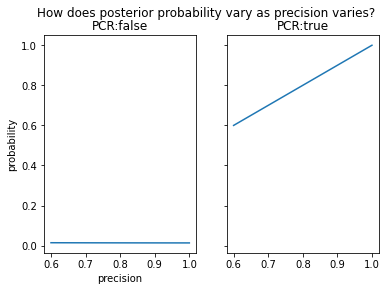

In [ ]:
X = np.linspace(.6, 1, 100)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('How does posterior probability vary as precision varies?')

for i, (ax,label) in enumerate(zip(axes, "false true".split())):
  ax.plot(X, [posterior_covid_precision(i, precision=x) for x in X])
  if not i:
    ax.set_ylabel("probability")
    ax.set_xlabel("precision")
  ax.set_title("PCR:%s" % label)

Precision seems to varies linearly with the posterior probability. It looks quite similar to the posterior in fact. This is nice. We can assert this:

In [ ]:
# Look! It's true! The precision is the posterior probabilty.
assert all(math.isclose(posterior_covid_precision(i, precision=p), p)
           for p in np.linspace(0.001,.999,100))

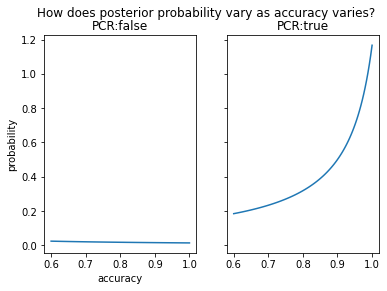

In [ ]:
X = np.linspace(.6, 1, 100)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('How does posterior probability vary as accuracy varies?')

for i, (ax,label) in enumerate(zip(axes, "false true".split())):
  ax.plot(X, [posterior_covid_accuracy(i, accuracy=x) for x in X])
  if not i:
    ax.set_ylabel("probability")
    ax.set_xlabel("accuracy")
  ax.set_title("PCR:%s" % label)

As accuracy improves, the posterior probability of a positive value goes up. We can now do the same thing we did with the prior&specificity investigation and see how varying priors affect how much accuracy impacts our posterior estimate.

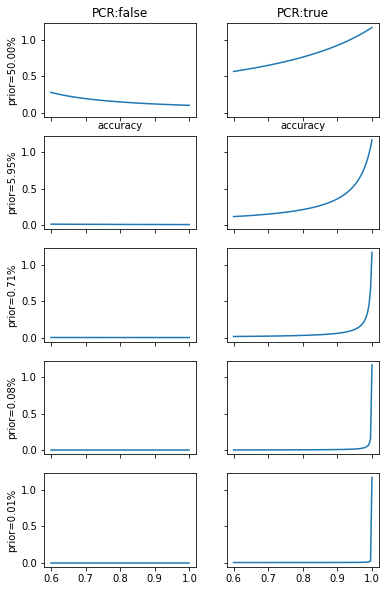

In [ ]:
priors = 10**np.linspace((np.log(.5) / np.log(10)), -4, 5)

fig, axes = plt.subplots(len(priors), 2, sharex=True, sharey=True)
for j, (prior, row) in enumerate(zip(priors, axes)):
  for i, (ax,label) in enumerate(zip(row, "false true".split())):
    ax.plot(X, [posterior_covid_accuracy(i, prevalence=prior, accuracy=x) for x in X])
    if not i and not j:
      ax.set_ylabel("probability")
    if not i:
      ax.set_ylabel("prior=%.2f%%" % (100*prior))
    if not j:
      ax.set_title("PCR:%s" % label)
      ax.set_xlabel("accuracy")

fig.set_figheight(10)